# Neural Artistic Style Transfer

This interactive notebook shows how to use the python package `style` for performing artistic style transfer between a source and a style image. 

Based on the work of

> Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). 
> A neural algorithm of artistic style. 
> https://arxiv.org/abs/1508.06576

Also incorporating ideas from

> Johnson, J., Alahi, A., & Fei-Fei, L. (2016, October). 
> Perceptual losses for real-time style transfer and super-resolution. 
> In European Conference on Computer Vision (pp. 694-711). Springer, Cham.
> https://arxiv.org/abs/1603.08155


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import torch
import numpy as np
from IPython.display import display, clear_output
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)

Import style

In [2]:
import style
st = style.IteratedStyleTransfer()

### Visualizing Style Transfer

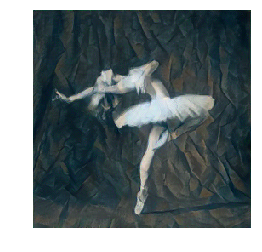

In [3]:
p = style.image.open('etc/dancing.jpg')
a = style.image.open('etc/picasso.jpg')
p = style.image.resize(p, (256,256))
a = style.image.resize(a, (256,256))

# Make sure we all see the same
torch.manual_seed(456)

# choose layers for content and style loss computation
c_id = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[4,8,12]] = 1

# get a generator object
g = st.iterate(p, a, c_id, style_weights, niter=500, lr=1e-2, x=p);

# and iterate (yields every 50 iterations)
fig, ax = plt.subplots()
img = ax.imshow(np.zeros_like(p))
ax.set_axis_off()

for x, l in g:
    clear_output(wait=True)
    img.set_data(x)
    display(fig)
clear_output(wait=True)



## Multiscale

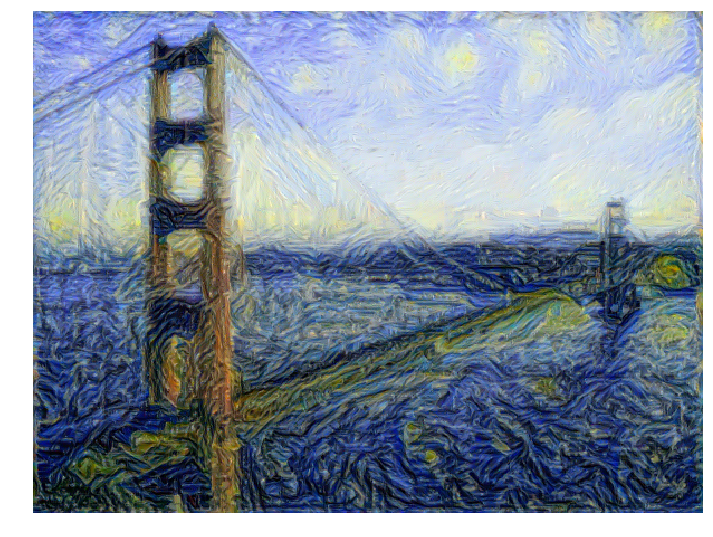

In [8]:
p = style.image.open('etc/bridge.JPG')
a = style.image.open('etc/vangogh.jpg')

sizes = style.image.Pyramid.image_sizes(p.shape, 4)[:-1]
cid = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[2,4,8,12]] = [1, 1, 0.6, 0.2]

imgs = []
for x,_ in st.iterate_multiscale(p, a, cid, style_weights, sizes, x=p, niter=100):
    imgs.append(x)
clear_output(wait=True)

imgs = [style.image.resize(img, sizes[-1]) for img in imgs]
data = np.hstack(imgs)
style.image.save('style.png', data)

plt.imshow(imgs[-1])
plt.axis('off')
plt.show()    

## Seamless

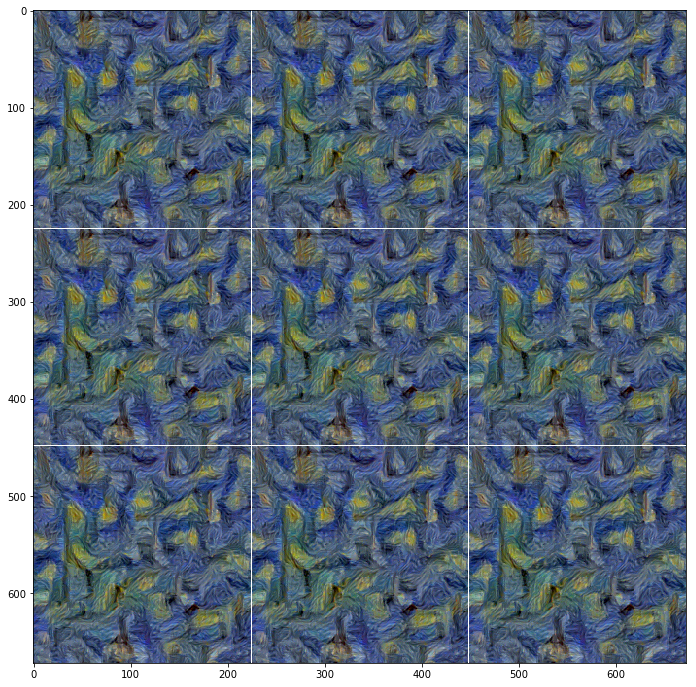

In [12]:
a = style.image.open('etc/vangogh.jpg')
a = style.image.resize(a, (256,256))

np.random.seed(456)
torch.manual_seed(456)

sizes = style.image.Pyramid.image_sizes(a.shape, 3)
cid = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[4,6,8]] = [1]

border = 16
seamless = style.plugins.SeamlessPlugin(a.shape, border)

x,_ = st.run_multiscale(a, a, cid, style_weights, sizes, niter=100, weight_content_loss=0, plugins=[seamless])
x = style.image.borderless_view(x, border)
clear_output(wait=True)

def gen_grid(x, border=True):
    hs = np.hstack((x,x,x))
    vs = np.vstack((hs,hs,hs))

    if border:
        h,w = x.shape[:2]       
        vs[:, [w,2*w]] = 1
        vs[[h,2*h]]=1

    return vs
        
gb = gen_grid(x, border=True)
g = gen_grid(x, border=False)
plt.figure(figsize=(12,12))
plt.imshow(gb)

In [59]:
style.image.save('seamless_border.png', gb)
style.image.save('seamless.png', g)

## Freezing regions

100%|███████████████████████████████████████| 150/150 [00:03<00:00, 38.31it/s, loss=[0.002 0.    0.002 0.   ], lr=0.01]


<function matplotlib.pyplot.show(*args, **kw)>

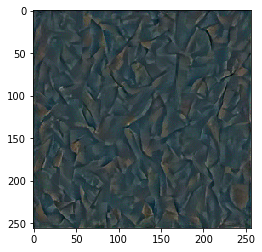

In [45]:
p = style.image.open('etc/dancing.jpg')
a = style.image.open('etc/picasso.jpg')
p = style.image.resize(p, (256,256))
a = style.image.resize(a, (256,256))

# Make sure we all see the same
torch.manual_seed(456)

# choose layers for content and style loss computation
c_id = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[4,8,12]] = 1

# get a generator object
x,_ = st.run(p, a, c_id, style_weights, niter=150, lr=1e-2, weight_content_loss=0, weight_tv_loss=0);

plt.imshow(x)
plt.show

#mask = np.zeros((256,256,1))
#mask[:, :128] = 1
#freeze = style.plugins.FreezePlugin(mask)


In [46]:
mask = np.zeros((256,256,1))
mask[:, :32] = 1
rec = style.plugins.ReconstructPlugin(mask, 1e1)

seq = [x]
for i in range(5):
    p = seq[-1].copy()
    p[:,:32] = p[:,-32:]
    newx,_ = st.run(p, a, c_id, style_weights, niter=200, lr=1e-2, weight_content_loss=0, weight_tv_loss=0, plugins=[rec]);
    seq.append(newx)


#plt.figure(figsize=(20,20))
#plt.imshow(newx)
#plt.show()


#style.image.save('first.png', x)
#style.image.save('gen.png', newx)

100%|███████████████████████████████████████| 200/200 [00:05<00:00, 38.38it/s, loss=[0.001 0.    0.001 0.   ], lr=0.01]


In [47]:
w = 256 * len(seq) - 32 * (len(seq) - 1)
final = np.empty((256,w,3))

o = 0
for img in seq:
    final[:, o:o+256, :] = img
    o += 256 - 32


In [48]:
style.image.save('final.png', final)